# Figure. Functional Annotation

In [1]:
import cPickle
import glob
import os
import random
import subprocess

import cdpybio as cpb
from ipyparallel import Client
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import pybedtools as pbt
from scipy.stats import fisher_exact
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels as sms
import tabix
import vcf as pyvcf
import weblogolib as logo

import cardipspy as cpy
import ciepy

%matplotlib inline
%load_ext rpy2.ipython

dy_name = 'figure_functional_annotation'

import socket
if socket.gethostname() == 'fl-hn1' or socket.gethostname() == 'fl-hn2':
    dy = os.path.join(ciepy.root, 'sandbox', 'tmp', dy_name)
    cpy.makedir(dy)
    pbt.set_tempdir(dy)
    
outdir = os.path.join(ciepy.root, 'output', dy_name)
cpy.makedir(outdir)

private_outdir = os.path.join(ciepy.root, 'private_output', dy_name)
cpy.makedir(private_outdir)

In [2]:
sns.set_style('whitegrid')

In [3]:
fn = os.path.join(ciepy.root, 'output', 'functional_annotation_analysis_new', 'encode_dnase_res.tsv')
encode_dnase_res = pd.read_table(fn, index_col=0)

fn = os.path.join(ciepy.root, 'output', 'functional_annotation_analysis_new', 'roadmap_dnase_res.tsv')
roadmap_dnase_res = pd.read_table(fn, index_col=0)

fn = os.path.join(os.path.split(cpy.roadmap_15_state_annotation)[0], 'epigenome_metadata.tsv')
roadmap_meta = pd.read_table(fn, index_col=0)

fn = os.path.join(os.path.split(cpy.roadmap_15_state_annotation)[0], 'EIDlegend.txt')
roadmap_ids = pd.read_table(fn, squeeze=True, index_col=0, header=None)

fn = os.path.join(ciepy.root, 'output', 'functional_annotation_analysis_new', 'encode_stem_cell_chip_seq_res.tsv')
tf_res = pd.read_table(fn, index_col=0)

## Process data

I'm going to subset the data a bit for plotting and print out some stats for the paper.
I also need to rename the cell lines and categories to have some consistency across the
two projects.

### DHS results

#### Roadmap

In [4]:
roadmap_dnase_res = roadmap_dnase_res.join(roadmap_meta[['GROUP', 'TYPE', 'ANATOMY']])
roadmap_dnase_res['name'] = roadmap_ids[roadmap_dnase_res.index].values

In [24]:
print('Tested {} Roadmap cell types.'.format(roadmap_dnase_res.shape[0]))

Tested 53 Roadmap cell types.


In [5]:
roadmap_meta.TYPE.value_counts()

PrimaryTissue     50
PrimaryCulture    38
PrimaryCell       25
ESCDerived         9
CellLine           5
Name: TYPE, dtype: int64

I can convert some of these labels directly, but some I have to break down.
In particular, there are a lot of things categorized as 'PrimaryCulture'.

In [6]:
sample_type_conv = {
    'PrimaryTissue':'Primary tissue',
    'PrimaryCulture':'Primary culture',
    'PrimaryCell':'Primary cell',
    'ESCDerived':'In vitro differentiated',
    'CellLine':'Immortalized line',
}

In [7]:
roadmap_dnase_res['my_cell_type'] = [sample_type_conv[x] for x in roadmap_dnase_res.TYPE]

I want to specifically label the stem and fetal cells from Roadmap.

In [8]:
roadmap_dnase_res.ix[roadmap_dnase_res.ANATOMY == 'IPSC', 'my_cell_type'] = 'Stem cell'
roadmap_dnase_res.ix[roadmap_dnase_res.ANATOMY == 'ESC', 'my_cell_type'] = 'Stem cell'
roadmap_dnase_res.ix[(roadmap_dnase_res.name.apply(lambda x: 'fetal' in x.lower())) & 
                     (roadmap_dnase_res.TYPE == 'PrimaryTissue'), 'my_cell_type'] = 'Primary fetal tissue'

Now I'll choose the top 25 cell types and rename them with more reasonable
and consistent names. For instance, ENCODE has both H1-hESC and H9 while 
Roadmap says "H1 Cell Line". These should be standardized. I also need to standardize
capitalization and weird stuff like "skin02" in the Roadmap names.

In [9]:
roadmap_dnase_res_f = roadmap_dnase_res.sort_values(by='pvalue', ascending=False).tail(25)

name_conv = {
    'Primary monocytes fromperipheralblood':'Peripheral blood monocytes',
    'Foreskin Fibroblast Primary Cells skin02':'Foreskin fibroblasts',
    'Fetal Adrenal Gland':'Fetal adrenal gland',
    'A549 EtOH 0.02pct Lung Carcinoma Cell Line':'A549 lung carcinoma line',
    'HSMM Skeletal Muscle Myoblasts Cell Line':'HSMM skeletal muscle myoblasts line',
    'Fetal Intestine Large':'Fetal large intestine',
    'NHLF Lung Fibroblast Primary Cells':'NHLF lung fibroblasts',
    'NH-A Astrocytes Cell Line':'NH-A astrocytes',
    'HUVEC Umbilical Vein Endothelial Cells Cell Line':'HUVEC umbilical vein endothelial cells',
    'Fetal Stomach':'Fetal stomach',
    'Primary hematopoietic stem cells G-CSF-mobilized Female':'Hematopoietic stem cells (G-CSF mobilized)',
    'Fetal Kidney':'Fetal kidney',
    'Breast variant Human Mammary Epithelial Cells (vHMEC)':'vHMEC breast variant mammary epithelial cells',
    'Fetal Lung':'Fetal lung',
    'Fetal Intestine Small':'Fetal small intestine',
    'Ovary':'Ovary',
    'Fetal Heart':'Fetal heart',
    'HepG2 Hepatocellular Carcinoma Cell Line':'HepG2 hepatocellular carcinoma line',
    'Pancreas':'Pancreas',
    'H1 Derived Neuronal Progenitor Cultured Cells':'H1 derived neuronal progenitors',
    'H1 BMP4 Derived Mesendoderm Cultured Cells':'H1 BMP4 derived mesendoderm',
    'iPS DF 6.9 Cell Line':'iPSC (DF 6.9)',
    'iPS DF 19.11 Cell Line':'iPSC (DF 19.11)',
    'H9 Cell Line':'H9 hESC',
    'H1 Cell Line':'H1 hESC'
}

roadmap_dnase_res_f['my_name'] = [name_conv[x] for x in roadmap_dnase_res_f.name]

#### ENCODE

In [10]:
tdf = encode_dnase_res[encode_dnase_res.biosample_type != 'immortalized cell line'].copy(deep=True)
a = tdf.shape[0]
b = tdf.cell_type.value_counts().shape[0]
print('Tested {} samples from {} cell types.'.format(a, b))
print('Tested {} skin fibroblast samples.'.format(sum(tdf.cell_type == 'skin fibroblast')))

Tested 123 samples from 78 cell types.
Tested 9 skin fibroblast samples.


In [11]:
tdf.sort_values(by='pvalue', inplace=True)
pos = ', '.join([str(x + 1) for x in np.where(tdf.cell_type == 'skin fibroblast')[0]])
print('The skin fibroblasts were in positions {} in the list of '
      'most enriched lines.'.format(pos))

The skin fibroblasts were in positions 11, 13, 22, 26, 29, 34, 44, 109, 121 in the list of most enriched lines.


In [12]:
encode_dnase_res.biosample_type.value_counts()

primary cell                          97
immortalized cell line                86
in vitro differentiated cells          9
tissue                                 8
stem cell                              5
induced pluripotent stem cell line     4
Name: biosample_type, dtype: int64

In [13]:
sample_type_conv = {
    'primary cell':'Primary cell',
    'immortalized cell line':'Immortalized line',
    'in vitro differentiated cells':'In vitro differentiated',
    'tissue':'Primary tissue',
    'stem cell':'Stem cell',
    'induced pluripotent stem cell line':'Stem cell',
}

In [14]:
encode_dnase_res['my_cell_type'] = [sample_type_conv[x] for x in encode_dnase_res.biosample_type]

Now I'll choose the top 25 cell types and rename them with more reasonable
and consistent names. [This site](http://genome.ucsc.edu/ENCODE/cellTypes.html)
has info on the ENCODE cell lines.

In [15]:
encode_dnase_res_f = encode_dnase_res.sort_values(by='pvalue', ascending=False).tail(25)

name_conv = {
    'H7-hESC':'H7 hESC',
    'H1-hESC':'H1 hESC',
    'cardiac fibroblast':'Cardiac fibroblasts',
    'MCF-7':'MCF-7 breast cancer line',
    'cardiac mesoderm':'Cardiac mesoderm',
    'skin fibroblast':'Skin fibroblasts',
    'dermis blood vessel endothelial cell':'Dermis blood vessel endothelium',
    'RWPE1':'RWPE1 prostate prostate epithelial line',
    'GM12865':'GM12865 lymphoblastoid line',
    'HCT116':'HCT116 colorectal carcinoma line',
    'HTR-8/SVneo':'HTR-8/SVneo trophoblast line',
    'myoblast':'Myoblasts',
    'urothelium cell line':'Urothelium line',
    'olfactory neurosphere cell line':'Olfactory neurosphere line',
    'induced pluripotent stem cell':'iPSC',
    'H9':'H9 hESC',
    'NT2/D1':'NT2/D1 pluripotent embryonal carcinoma line',
}

encode_dnase_res_f['my_name'] = [name_conv[x] for x in encode_dnase_res_f.cell_type]

### TF results

I'll drop duplicate TF results (keeping the most significant). I also want
to remove experiments that aren't for TFs.

In [16]:
tf_res = tf_res.sort_values(by='pvalue').drop_duplicates(subset=['target'])
tf_res.target_type.value_counts()

transcription factor                                                                                39
chromatin remodeller, transcription factor                                                           8
RNA binding protein, transcription factor                                                            3
broad histone mark, histone, histone modification                                                    2
histone, histone modification, narrow histone mark                                                   1
chromatin remodeller, other context, other post-translational modification, transcription factor     1
Name: target_type, dtype: int64

I'll keep all of the categories that have "transcription factor."

In [17]:
tf_res = tf_res[(tf_res.target_type != 'broad histone mark, histone, histone modification') & 
                (tf_res.target_type != 'histone, histone modification, narrow histone mark')]

I'll also remove Pol2.

In [18]:
tf_res = tf_res.drop(tf_res[tf_res.target.apply(lambda x: 'POLR2A' in x)].index)

In [19]:
print('We have {} TF experiments.'.format(tf_res.shape[0]))
n = np.where(tf_res.target == 'NANOG')[0][0]
print('NANOG is #{} in the list of most enriched TF.'.format(n + 1))
n = np.where(tf_res.target == 'POU5F1')[0][0]
print('POU5F1 is #{} in the list of most enriched TF.'.format(n + 1))

We have 49 TF experiments.
NANOG is #1 in the list of most enriched TF.
POU5F1 is #3 in the list of most enriched TF.


In [20]:
tf_res_f = tf_res[tf_res.pvalue < 0.05]

## Paper

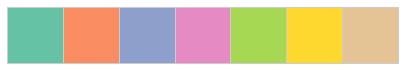

In [21]:
sns.palplot(sns.color_palette('Set2', 7))

In [22]:
cdict = dict(zip(set(roadmap_dnase_res.my_cell_type) | set(encode_dnase_res.my_cell_type), 
                 sns.color_palette('Set2', 7)))

/frazer01/home/cdeboever/software/anaconda/envs/cie/lib/python2.7/site-packages/matplotlib/gridspec.py:302: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


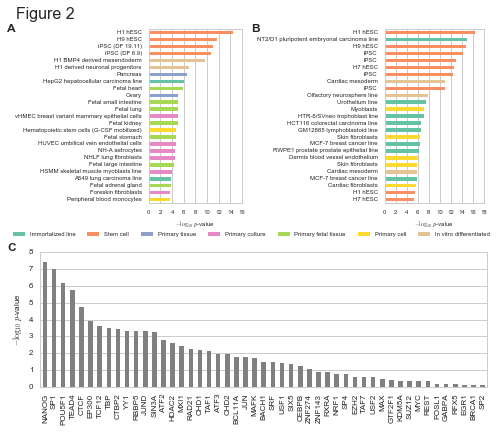

In [23]:
fig = plt.figure(figsize=(6.85, 6.1), dpi=300)

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.text(0, 1, 'Figure 2',
        size=16, va='top')
ciepy.clean_axis(ax)
ax.set_xticks([])
ax.set_yticks([])
gs.tight_layout(fig, rect=[0, 0.90, 0.5, 1])

# Roadmap DNase
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])

c = [cdict[x] for x in roadmap_dnase_res_f.my_cell_type]
(-np.log10(roadmap_dnase_res_f.pvalue)).plot(kind='barh', ax=ax, color=c, lw=0)
ax.set_xlabel('$-\log_{10}$ $p$-value', fontsize=6)
ax.set_ylabel('')
ax.grid(axis='y')
ax.set_yticklabels(roadmap_dnase_res_f.my_name, fontsize=6)

for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(6)
gs.tight_layout(fig, rect=[0, 0.45, 0.51, 0.95])

# ENCODE DNase
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])

c = [cdict[x] for x in encode_dnase_res_f.my_cell_type]
ax = (-np.log10(encode_dnase_res_f.pvalue)).plot(kind='barh', ax=ax, color=c, label=None, lw=0)
ax.set_xlabel('$-\log_{10}$ $p$-value', fontsize=6)
ax.set_ylabel('')
ax.grid(axis='y')
ax.set_yticklabels(encode_dnase_res_f.my_name, fontsize=6)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(6)
gs.tight_layout(fig, rect=[0.49, 0.45, 1, 0.95])

# Color legend
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ciepy.clean_axis(ax)
rects = []
labels = []
for k in cdict.keys():
    if k == 'induced pluripotent stem cell line':
        labels.append('iPSC')
    elif k == 'in vitro differentiated cells':
        labels.append('in vitro\ndifferentiated\ncell')
    elif k == 'immortalized cell line':
        labels.append('immortalized\ncell line')
    else:
        labels.append(k)
    r = plt.Rectangle((0, 0), 0, 0, fc=cdict[k])
    rects.append(r)
lgd = ax.legend(rects, labels, loc='upper center', fontsize=6, ncol=7)
for p in lgd.get_patches():
    p.set_linewidth(0)
    
gs.tight_layout(fig, rect=[0, 0.45, 1, 0.5])

# ENCODE ChIP-seq
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])

(-np.log10(tf_res.pvalue)).plot(ax=ax, kind='bar', color='grey', lw=0)
ax.set_ylabel('$-\log_{10}$ $p$-value', fontsize=8)
ax.set_xlabel('')
ax.grid(axis='x')
ax.set_xticklabels(tf_res.target, fontsize=8)
for t in ax.get_yticklabels():
    t.set_fontsize(8)
gs.tight_layout(fig, rect=[0, 0, 1, 0.45])

t = fig.text(0.005, 0.92, 'A', weight='bold', 
             size=12)
t = fig.text(0.5, 0.92, 'B', weight='bold', 
             size=12)
t = fig.text(0.005, 0.42, 'C', weight='bold', 
             size=12)

fig.savefig(os.path.join(outdir, 'functional_annotation.pdf'))
fig.savefig(os.path.join(outdir, 'functional_annotation.png'), dpi=300)

In [40]:
3 + 

## Presentation

In [ ]:
fig = plt.figure(figsize=(10, 6.5), dpi=300)

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
t = dnase_res[dnase_res.biosample_type != 'immortalized cell line']
t = dnase_res.ix[t.index].sort_values(by='pvalue', ascending=False).tail(20)
# cdict = dict(zip(set(dnase_res.ix[t.index, 'biosample_type']), sns.color_palette('Set2')))
cdict = dict([['induced pluripotent stem cell line', cpb.analysis.tableau20[0]],
              ['stem cell', cpb.analysis.tableau20[4]],
              ['in vitro differentiated cells', cpb.analysis.tableau20[6]],
              ['primary cell', cpb.analysis.tableau20[8]], 
              ['tissue', cpb.analysis.tableau20[10]]])
#fig, ax = plt.subplots(1, 1, figsize=(5, 10))
c = [cdict[x] for x in dnase_res.ix[t.index, 'biosample_type']]
ax = (-np.log10(t.pvalue)).plot(kind='barh', ax=ax, color=c, label=None)
ax.set_ylabel('')
ax.set_xlabel('$-\log_{10}$ $p$-value', fontsize=16)
#ax.set_title('ENCODE DNase enrichments')
ya, yb = ax.get_ylim()
ax.set_yticklabels(dnase_res.ix[t.index, 'cell_type'], fontsize=8)
rects = []
labels = []
for k in ['induced pluripotent stem cell line', 'stem cell',
          'in vitro differentiated cells', 'primary cell', 'tissue']:
    if k == 'induced pluripotent stem cell line':
        labels.append('iPSC')
    elif k == 'in vitro differentiated cells':
        labels.append('in vitro\ndifferentiated\ncell')
    else:
        labels.append(k)
    r = plt.Rectangle((0, 0), 0, 0, fc=cdict[k])
    rects.append(r)
lgd = ax.legend(rects, labels, loc='lower right', frameon=True, fontsize=12)
#bbox_to_anchor=[0.5, -0.05])#, prop={'size':8}), loc='upper center',
for p in lgd.get_patches():
    p.set_linewidth(0)
ax.grid(axis='y')
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(12)
ax.set_title('ENCODE DHS')
gs.tight_layout(fig, rect=[0, 0, 0.6, 1])

gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
t = tf_res.sort_values(by='pvalue', ascending=False).tail(20)
ax = (-np.log10(t.pvalue)).plot(kind='barh', ax=ax, color='grey')
ax.set_ylabel('')
ax.set_xlabel('$-\log_{10}$ $p$-value', fontsize=16)
ya, yb = ax.get_ylim()
t = ax.set_yticklabels(t.target, fontsize=8)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(12)
ax.grid(axis='y')
ax.set_title('H1-hESC Transcription Factor ChIP-Seq')
gs.tight_layout(fig, rect=[0.6, 0, 1, 1])

fig.savefig(os.path.join(outdir, 'dnase_tf_presentation.pdf'))

In [ ]:
fig,ax = plt.subplots(1, 1, figsize=(10, 6.5), dpi=300)

grasp_res.sort_values(by='pvalue', inplace=True)
t = grasp_res[grasp_res.bh_sig]

sns.boxplot(data=grasp_counts.ix[t.index, grasp_counts.columns[1:]].T, ax=ax, orient='h')
ax.scatter(grasp_counts.ix[t.index, 'real'], range(t.shape[0]), alpha=0.5, s=100)

xmin, xmax = ax.get_xlim()
# for i in range(se.shape[0]):
#     ax.text(0.97 * xmax, i, se.values[i], va='center', ha='center')
ax.set_xlabel('Number of overlaps', fontsize=16)
ax.set_xlim(0, xmax)
ax.set_ylabel('')
for tick in ax.get_xticklabels() + ax.get_yticklabels():
    tick.set_fontsize(16)

ymin,ymax = ax.get_ylim()
ax2 = ax.twiny()
ax2.set_xlabel('$-\log_{10}$ Fisher $p$-value', fontsize=16)
h = 0.5
step = abs(ymax - ymin) / t.shape[0]
b = np.arange(ymax, ymin, step) + (step / 2 - h / 2)
ax2.barh(b, -np.log10(grasp_res.ix[t.index, 'pvalue']), height=h, alpha=0.5)
ax.set_ylim(ymin, ymax)
#ax.set_xlim(0, 50)
ax.grid(axis='x')
ax2.grid(axis='x')
ax.grid('x', zorder=4)
for tick in ax2.get_xticklabels() + ax2.get_yticklabels():
    tick.set_fontsize(16)
    
fig.tight_layout()

fig.savefig(os.path.join(outdir, 'gwas_presentation.pdf'))

In [ ]:
fs = 10

fig = plt.figure(figsize=(6.8, 4), dpi=300)

# Number of eGenes vs. number of samples
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(plotd.ix[plotd.source == 'gtex', 'num_samples'], 
           plotd.ix[plotd.source == 'gtex', 'num_sig_genes'],
           label='GTEx', color=cpb.analysis.tableau20[0], s=30, alpha=0.75)
ax.scatter([plotd.ix['ipsc_unrelateds', 'num_samples']], 
           [plotd.ix['ipsc_unrelateds', 'num_sig_genes']],
           label='iPSC 131 unrelateds', color=cpb.analysis.tableau20[2], alpha=0.75, s=50,
           marker='*')
ax.scatter([plotd.ix['ipsc', 'num_samples']], 
           [plotd.ix['ipsc', 'num_sig_genes']],
           label='iPSC', color=cpb.analysis.tableau20[2], alpha=0.75, s=30)
ax.set_xlabel('Number of samples', fontsize=fs)
ax.set_ylabel('Number of eGenes', fontsize=fs)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(fs)
lgd = ax.legend(loc='upper center', bbox_to_anchor=(1.35, 1))
ax.yaxis.set_major_formatter(ciepy.comma_format)
gs.tight_layout(fig, rect=[0, 0.5, 0.5, 1])

# Percent distinct eGenes
gs = gridspec.GridSpec(1, 1)
ax = fig.add_subplot(gs[0, 0])
ax.scatter(plotd.ix[plotd.source == 'gtex', 'num_samples'], 
           plotd.ix[plotd.source == 'gtex', 'percent_distinct_egenes'],
           label='GTEx', color=cpb.analysis.tableau20[0], s=30, alpha=0.75)
ax.scatter([plotd.ix['ipsc_unrelateds', 'num_samples']], 
           [plotd.ix['ipsc_unrelateds', 'percent_distinct_egenes']],
           label='iPSC 131 unrelateds', color=cpb.analysis.tableau20[2], alpha=0.75, s=30)
ax.scatter([plotd.ix['ipsc', 'num_samples']], 
           [plotd.ix['ipsc', 'percent_distinct_egenes']],
           label='iPSC', color=cpb.analysis.tableau20[2], alpha=0.75, s=50, marker='*')
ax.set_xlabel('Number of samples', fontsize=fs)
ax.set_ylabel('Percent unique eGenes', fontsize=fs)
for t in ax.get_xticklabels() + ax.get_yticklabels():
    t.set_fontsize(fs)
#ax.legend(frameon=True, fancybox=True, fontsize=fs, loc='upper right')
ymin,ymax = ax.get_ylim()
ax.set_ylim(0, ymax)
gs.tight_layout(fig, rect=[0, 0, 0.5, 0.5])

fig.savefig(os.path.join(outdir, 'power_presentation.pdf'))